(content:references:transits_part1)=
# Planetary Transits Part 1: *Observing Transits*

In this chapter, we will explore how Convolutional Neural Networks are used to identify signals in photometric time series that potentially belong to a planet.

When a planet passes in front of our line-of-sight of a star, it blocks a fraction of the incoming starlight, which will manifest as dips in the light curve that are denoted as **transits**.


```{figure} images/transit.png
---
height: 600px
width: 750px
name: transit_schematic
---
Schematic of a planetary transit. The upper diagram shows a planet (black circle) crossing the disk of its host star, which induces a reduction in the observed flux over time. The lower diagram shows the flux over time from the star, where a characteristic dip is seen during the transit. Parameters like $T$ (transit duration), $\delta$ (transit depth), $b$ (impact parameter), and $\tau$ characterize the nature of the transit, which provide information into the nature of the planet's physical and orbital properties. Image from {cite}`Winn_2010`.
```


In [1]:
import os
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import batman
import scienceplots

from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.colors import Normalize
from copy import copy

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter1' / 'data'

plt.style.use('science')

fs = 18

## Simulated Planetary Transits

To visualize a planetary transit and how the characteristics of the planet, star, and the orbit may influence the shape of the observed light curve, we will use the [`batman`](https://lkreidberg.github.io/batman/) library.

Let's visualize a simple light curve.

In [3]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 1.                       #orbital period
params.rp = 0.1                       #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = np.linspace(-0.025, 0.025, 1000)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model

```{note}
The units of time are allowed to be anything with `batman`, as long as they are consistent across different time variables.
```

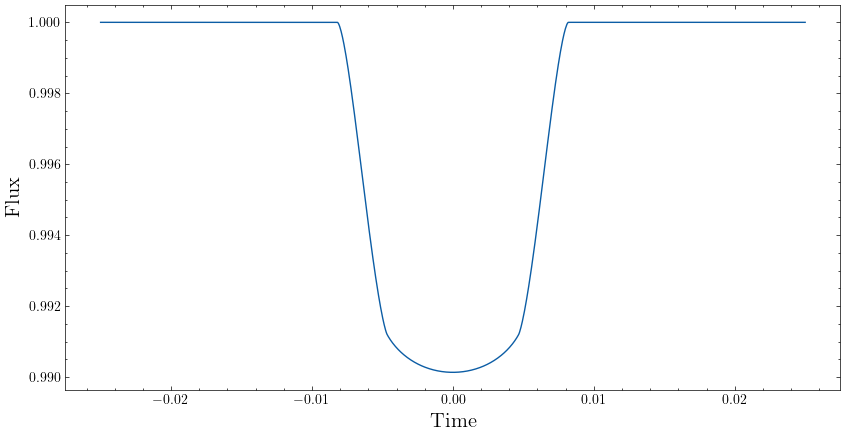

In [4]:
fig = plt.figure(figsize=(10, 5));ax1 = fig.add_subplot(111)
ax1.plot(t, m.light_curve(params))
ax1.set_xlabel('Time', fontsize=fs-3);ax1.set_ylabel('Flux', fontsize=fs-3)    
plt.show()

Let's visualize what happens when changing certain elementary parameters, such as the size of the planet and its distance from the host star.

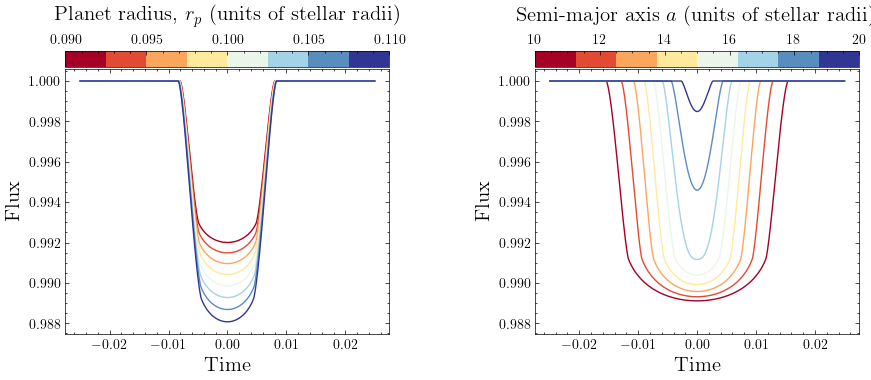

In [5]:
N = 8
cmap = mpl.colormaps['RdYlBu'].resampled(N)
rp_range = np.linspace(0.09, 0.11, N); a_range = np.linspace(10, 20, N)
norm_rp = Normalize(vmin=min(rp_range), vmax=max(rp_range))
norm_a = Normalize(vmin=min(a_range), vmax=max(a_range))

fig = plt.figure(figsize=(10, 5))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)

for i, rp in enumerate(rp_range):
    params_new = copy(params)
    params_new.rp = rp
    ax1.plot(t, m.light_curve(params_new), color = cmap(i / ((N) - 1)))
    
for i, a in enumerate(a_range):
    params_new = copy(params)
    params_new.a = a
    ax2.plot(t, m.light_curve(params_new), color = cmap(i / ((N) - 1)))
ax2.set_ylim(ax1.get_ylim())
ax1.set_xlabel('Time', fontsize=fs-3); ax2.set_xlabel('Time', fontsize=fs-3)
ax1.set_ylabel('Flux', fontsize=fs-3); ax2.set_ylabel('Flux', fontsize=fs-3)
sm = cm.ScalarMappable(cmap=cmap, norm=norm_rp)
sm.set_array(N)
cbar = fig.colorbar(sm, ax=ax1, orientation='horizontal', pad=0.005,location='top')
cbar.set_label('Planet radius, $r_p$ (units of stellar radii)', fontsize=fs-3, labelpad=10)
cbar.ax.xaxis.set_ticks_position('top')  # Move ticks to the top
cbar.ax.xaxis.set_label_position('top')


sm = cm.ScalarMappable(cmap=cmap, norm=norm_a)
sm.set_array(N)
cbar = fig.colorbar(sm, ax=ax2, orientation='horizontal', pad=0.005,location='top')
cbar.set_label('Semi-major axis $a$ (units of stellar radii)', fontsize=fs-3, labelpad=10)
cbar.ax.xaxis.set_ticks_position('top')  # Move ticks to the top
cbar.ax.xaxis.set_label_position('top')

plt.tight_layout(pad=5)
plt.show() 

```{note}
Why does changing $a$ affect **both** the depth and the duration of the transit?
```

```{admonition} Exercise
:class: seealso
Transiting planets are assumed to have near **edge-on** orbits. That is, their orbits are tilted such that they align with our line of sight to the star ($i\sim90^{\circ}$). 

```{figure} images/inclinations.png
---
height: 350px
width: 400px
name: inclinations
---
Schematic of orbital inclinations, presented by {cite}`Todorov_2008`.


Experiment with adjusting the inclination angle for the simulated transits (`params.inc`). Observe what happens to the shape of the light curve. What happens when you tilt the angle past a certain degree, and why does this happen?

:::{hint}
:class: dropdown
The inclination angle of the planet's orbit affects the impact parameter $b$. At some sufficiently low inclination angle, the orbit becomes so tilted such that the planet no longer crosses the stellar disk within our line of sight.

```{figure} images/exoplanet-orbits-lco.png
---
height: 550px
name: lco-orbit
---
Image credit: [LCO](https://lco.global/spacebook/exoplanets/transit-method/)
```

:::
```

## Observed Planetary Transits

Let's observe how transits appear in real data collected by NASA's TESS mission. In the following, we have the light curve of TIC 200473154, which appears to have a transit every $\sim$12 days.


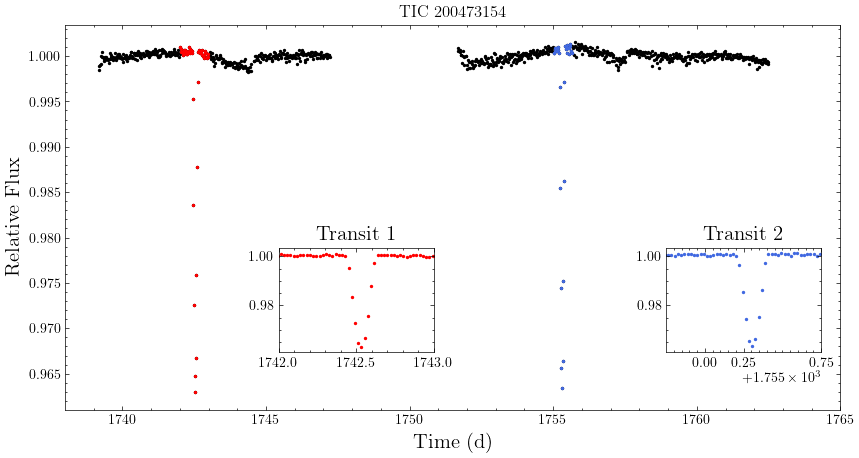

In [362]:
df = fits.open(os.path.join(data_folder_path, 'astronet_tess_ffi_s0039-0000000200473154_tess_v01_llc.fits'))
t, f = df[1].data['TIME'][df[1].data['QUALITY'] == 0], df[1].data['SAP_FLUX'][df[1].data['QUALITY'] == 0]
fig = plt.figure(figsize=(10, 5));ax1 = fig.add_subplot(111)
ax1.scatter(t, f, c='k', s=2)
ax1.scatter(t[(t>= 1742) & (t <= 1743)],
            f[(t>= 1742) & (t <= 1743)], c='r', s=2)
ax1.scatter(t[(t>= 1755) & (t <= 1755.65)],
            f[(t>= 1755) & (t <= 1755.65)], c='royalblue', s=2)

ax1.set_xlabel('Time (d)', fontsize=fs-3); ax1.set_ylabel('Relative Flux', fontsize=fs-3)
ax1.set_title('TIC 200473154')
ax1.set_xlim(None, 1765)
ax1a = ax1.inset_axes(
    [0.275, 0.15, 0.2, 0.27],
    xlim=(1742, 1743)) # , ylim=(y1, y2)
ax1a.set_xticks([1742, 1742.5, 1743])
ax1a.scatter(t, f, c='r', s=2)
ax1a.set_title('Transit 1', fontsize=fs-3)

ax1b = ax1.inset_axes(
    [0.775, 0.15, 0.2, 0.27],
    xlim=(1754.75, 1755.75)) # , ylim=(y1, y2)
ax1b.set_xticks([1755, 1755.25, 1755.75])
ax1b.scatter(t, f, c='royalblue', s=2)
ax1b.set_title('Transit 2', fontsize=fs-3)
plt.show()

## Detecting periodic transits

To detect the presence of a periodic dip in a light curve, the Box Least-Squares (BLS) periodogram is often deployed. The periodogram performs least-squares fitting of a template comprising periodic, box-like dips to the light curve, optimizing for a period that best matches what is seen in the observed data.

```{figure} images/bls-1.png
---
height: 350px
name: bls
---
Schematic of transit template used by the Box Least-Squares (BLS) periodogram.  Image from [astropy](https://docs.astropy.org/en/stable/timeseries/bls.html).
```

```{important}
BLS performs a grid search over a range of parameters that adjusts the shape of template, namely transit period, duration, and depth. To be computationally efficient, BLS implementations often scan over a grid of period values, while the depth and duration can be kept constant to some characteristic value.
```
Below, we will use the BLS implementation from  `astropy.timeseries.BoxLeastSquares`.

In [363]:
from astropy.timeseries import BoxLeastSquares
import astropy.units as u

model = BoxLeastSquares(t * u.day, f)
periodogram = model.power(duration = 0.2* u.day, period = np.linspace(2, 15, 1000) * u.day)

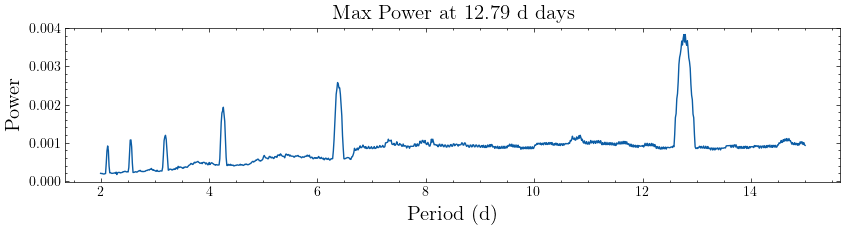

In [364]:
def plot_bls_spectrum(periodogram):
    plt.figure(figsize=(10, 2))
    plt.plot(periodogram.period, periodogram.power)
    plt.xlabel('Period (d)', fontsize=fs-3)
    plt.ylabel('Power', fontsize=fs-3)
    plt.title(f'Max Power at {periodogram.period[np.argmax(periodogram.power)]:.2f} days', fontsize=fs-3); plt.show()
    plt.show()
    
plot_bls_spectrum(periodogram)

The correct transit period often occurs at the period at which the BLS power is a maximum. We often would also like to visualize the transit shape across all events, which we can do by 'folding' the light curve at the period of the transit and expressing the products in fractional units of the period, also called **phase**. This yields a so-called phase-folded light curve.

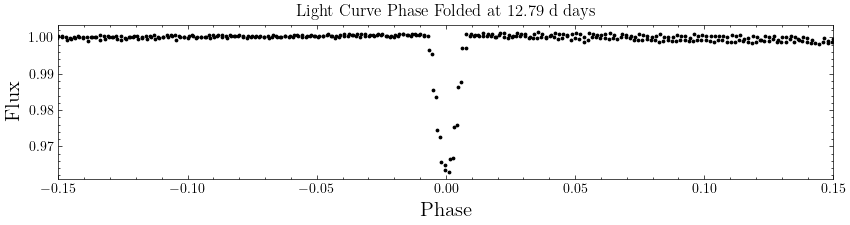

In [365]:
def plot_phase_folded(periodogram, xlim=(-0.5, 0.5)):
    centered_phase = np.mod(t - periodogram.transit_time[np.argmax(periodogram.power)].value, periodogram.period[np.argmax(periodogram.power)].value)/periodogram.period[np.argmax(periodogram.power)].value
    centered_phase[centered_phase > 0.5] -= 1
    plt.figure(figsize=(10, 2))
    plt.scatter(centered_phase, f, s=3, c='k')
    plt.xlim(xlim); plt.xlabel('Phase', fontsize=fs-3); plt.ylabel('Flux', fontsize = fs-3)
    plt.title(f'Light Curve Phase Folded at {periodogram.period[np.argmax(periodogram.power)]:.2f} days');plt.show()
    
plot_phase_folded(periodogram, xlim=(-0.15, 0.15))

## Confounding observations

The essence of planetary searches with the transit method is to detect the presence of periodic dips from a planet, often using the BLS algorithm to automate the process.

However, there are often other sources of stellar phenomena that may fool the BLS algorithm by occurring at regular intervals and appearing to dim the light curve.

### Example Confounders: Stellar Pulsations/Starspots

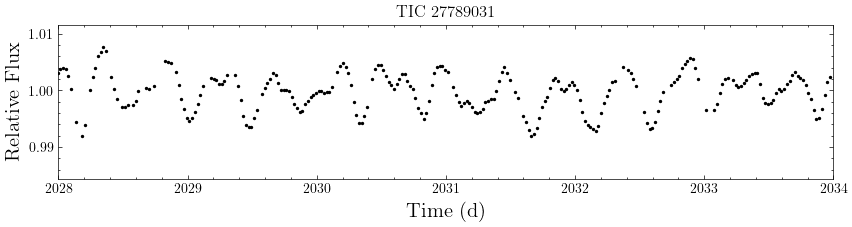

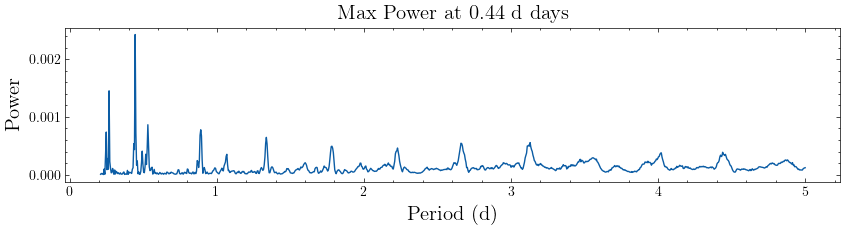

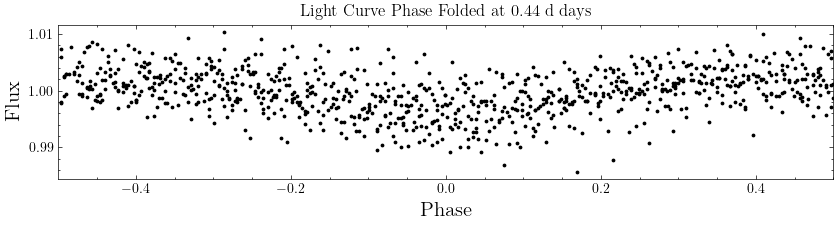

In [366]:
## Helper Function to plot lightcurves

def plot_lc(tic, xlim=None, ylim=None):
    try:
        df = fits.open(f'/home/marc/notebooks/astronet/LC/astronet_tess_ffi_s0039-0000000{tic}_tess_v01_llc.fits')
    except:
        df = fits.open(f'/home/marc/notebooks/astronet/LC/astronet_tess_ffi_s0039-00000000{tic}_tess_v01_llc.fits')
        
    # df = fits.open('/home/marc/notebooks/astronet/LC/astronet_tess_ffi_s0039-0000000025117240_tess_v01_llc.fits')
    t, f = df[1].data['TIME'][df[1].data['QUALITY'] == 0], df[1].data['SAP_FLUX'][df[1].data['QUALITY'] == 0]
    fig = plt.figure(figsize=(10, 2));ax1 = fig.add_subplot(111)
    ax1.scatter(t, f, c='k', s=2)
    ax1.set_xlabel('Time (d)', fontsize=fs-3); ax1.set_ylabel('Relative Flux', fontsize=fs-3)
    ax1.set_title(f'TIC {tic}')
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    plt.show()
    return t, f

t, f = plot_lc(27789031, xlim=(2028, 2034)) ## Example: Stellar Pulsations 
model = BoxLeastSquares(t * u.day, f)
periodogram = model.power(duration = 0.2* u.day, period = np.linspace(0.21, 5, 1000) * u.day)
plot_bls_spectrum(periodogram)
plot_phase_folded(periodogram, xlim=(-0.5, 0.5))

### Example Confounders: Starspots on Rotating Stars

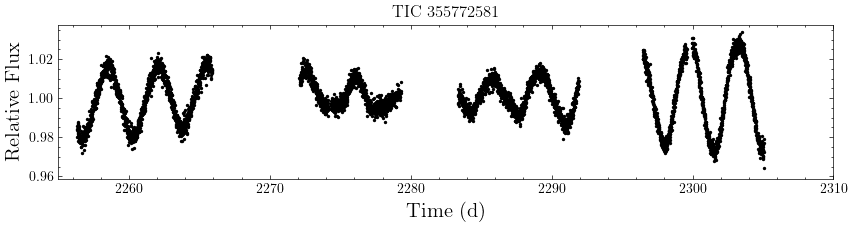

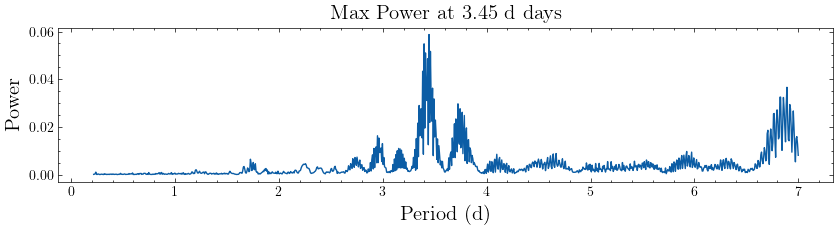

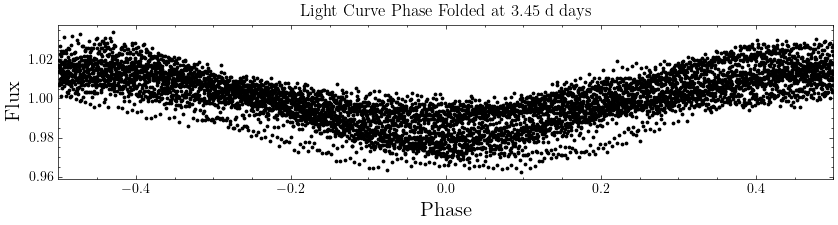

In [367]:
t, f = plot_lc(355772581, xlim=(2255, 2310)) ## Example: Stellar Pulsations 

model = BoxLeastSquares(t * u.day, f)
periodogram = model.power(duration = 0.2* u.day, period = np.linspace(0.21, 7, 1000) * u.day)
plot_bls_spectrum(periodogram)
plot_phase_folded(periodogram , xlim=(-0.5, 0.5))

### Example Confounders: Eclipsing Binaries

:::{note}
How do we distinguish eclipses from a planet candidate versus eclipses from a companion star?
:::

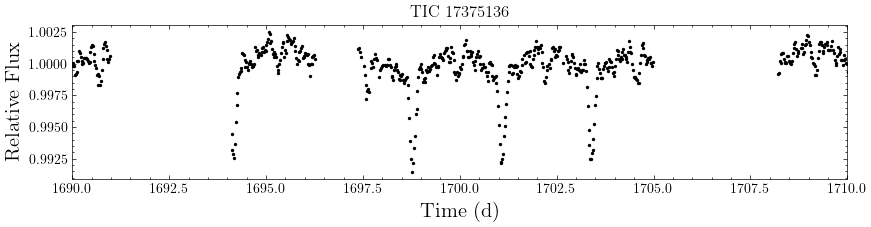

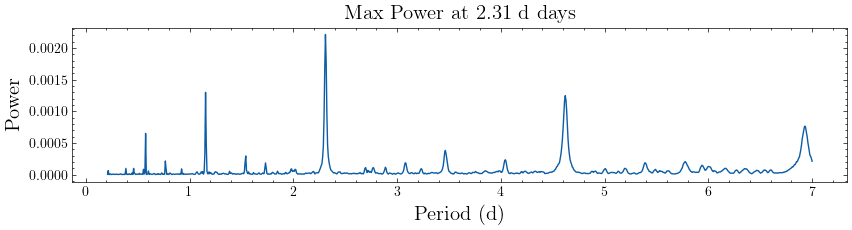

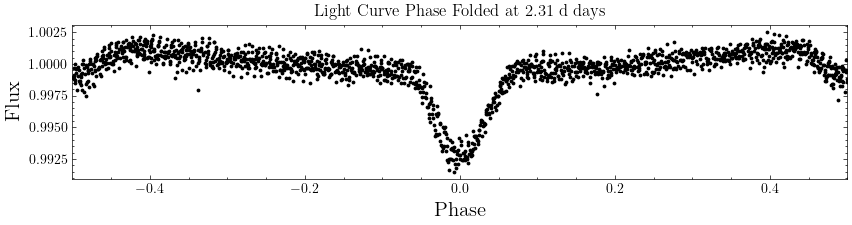

In [368]:
t, f = plot_lc(17375136, xlim = (1690, 1710)) ## Example: Stellar Pulsations 
model = BoxLeastSquares(t * u.day, f)
periodogram = model.power(duration = 0.2* u.day, period = np.linspace(0.21, 7, 1000) * u.day)
plot_bls_spectrum(periodogram)
plot_phase_folded(periodogram , xlim=(-0.5, 0.5))

### Example Confounders: Gaps in Data/Instrumental Artifacts

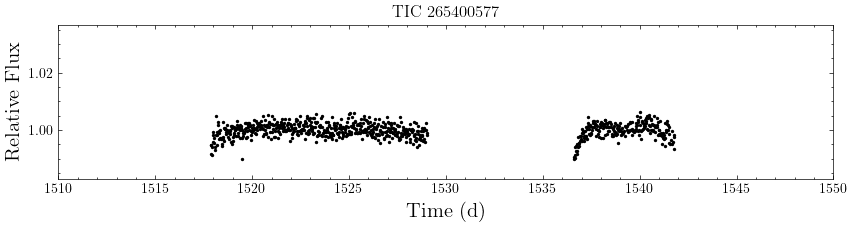

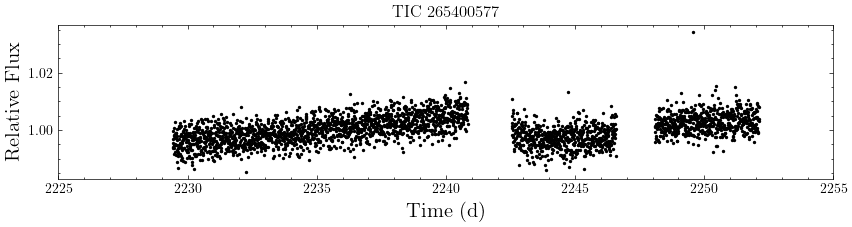

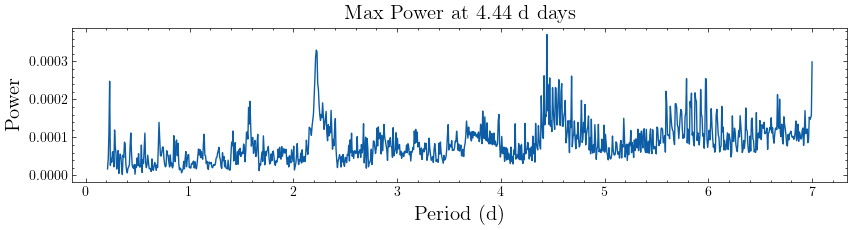

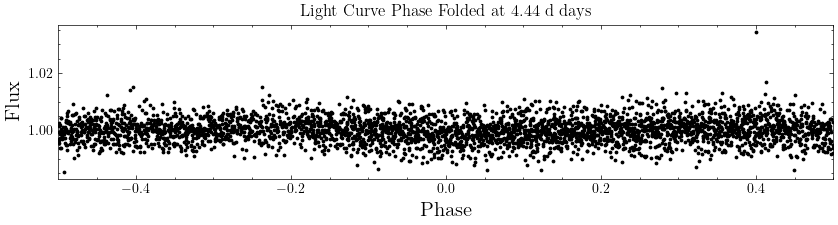

In [369]:
t, f = plot_lc(265400577, xlim=(1510, 1550)) 
t, f = plot_lc(265400577, xlim=(2225, 2255)) 

model = BoxLeastSquares(t * u.day, f)
periodogram = model.power(duration = 0.2* u.day, period = np.linspace(0.21, 7, 1000) * u.day)
plot_bls_spectrum(periodogram)
plot_phase_folded(periodogram , xlim=(-0.5, 0.5))

It's clear that these confounders also produce fairly peaked signals in the BLS periodogram. Notice, however, that the morphology (or shape) of the phase-folded light curves look vastly different across these different sources of periodicity! This is the key difference that will be utilized to single out potential planet candidates. 


## BLS Libraries

Some of the other open source libraries to running the BLS algorithm in Python are the following:

[[1]](https://johnh2o2.github.io/cuvarbase/bls.html) `cuvarbase`

[[2]](https://docs.astropy.org/en/stable/api/astropy.timeseries.BoxLeastSquares.html) `astropy`'s BLS implementation

[[3]](https://transitleastsquares.readthedocs.io) `transitleastsquares`

[[4]](https://github.com/PrincetonUniversity/FastTemplatePeriodogram) `FastTemplatePeriodogram`